In [96]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

In [97]:
stock_data = pd.read_csv('../data/sp500_historical_data.csv')

In [98]:
close_data = stock_data.pivot(index='Date', columns='Symbol', values='Close')
close_data = close_data.dropna(how="all", axis=1)  # Remove columns with all NaNs
# Convert Date to datetime
close_data.index = pd.to_datetime(close_data.index)

In [99]:
def add_index_data(stock_data):
    spy = yf.download('^GSPC', start=stock_data.index.min(), end=stock_data.index.max())['Adj Close']
    nasdaq = yf.download('^IXIC', start=stock_data.index.min(), end=stock_data.index.max())['Adj Close']
    interest_rate = yf.download('^TNX', start=stock_data.index.min(), end=stock_data.index.max())['Adj Close']
    vix = yf.download('^VIX', start=stock_data.index.min(), end=stock_data.index.max())['Adj Close']
    
    stock_data['S&P500'] = spy
    stock_data['Nasdaq'] = nasdaq
    stock_data['InterestRate'] = interest_rate
    stock_data['VIX'] = vix
    
    return stock_data

# Add index data to the dataset
close_data = add_index_data(close_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [100]:
sma_50 = close_data.apply(lambda x: x.rolling(window=50).mean())
sma_200 = close_data.apply(lambda x: x.rolling(window=200).mean())

# Calculate momentum for each stock
def calculate_momentum(sma_50, sma_200):
    """Calculate momentum by dividing SMA_50 by SMA_200."""
    momentum = sma_50 / sma_200
    return momentum

momentum = calculate_momentum(sma_50, sma_200)

In [101]:
# Calculate rolling correlation with S&P500 and Nasdaq for each stock
def calculate_correlation(stock_data, index_col, window=21):
    """Calculate rolling correlation between each stock and the given index."""
    return stock_data.apply(lambda x: x.rolling(window=window).corr(stock_data[index_col]))

# Calculate the correlations
corr_sp500 = calculate_correlation(close_data, 'S&P500')
corr_nasdaq = calculate_correlation(close_data, 'Nasdaq')
corr_interest_rate = calculate_correlation(close_data, 'InterestRate')
corr_vix = calculate_correlation(close_data, 'VIX')

In [102]:
def calculate_scores(close_data, momentum, corr_sp500, corr_nasdaq, rebalance_dates):
    """
    Calculate monthly scores for each stock using z-scores and normalized rankings.
    
    Parameters:
    close_data: DataFrame containing close prices for stocks
    momentum: DataFrame containing calculated momentum for stocks
    corr_sp500: DataFrame containing rolling correlation with S&P 500 for each stock
    corr_nasdaq: DataFrame containing rolling correlation with Nasdaq for each stock
    rebalance_dates: List of dates at the end of each month for rebalancing
    
    Returns:
    scores: DataFrame of monthly scores for each stock
    """
    
    scores_list = []
    
    for rebalance_date in rebalance_dates:
        closest_date = momentum.index.asof(rebalance_date)
        
        # Get the latest available values for momentum and correlations up to the rebalance date
        current_momentum = momentum.loc[closest_date].dropna()
        current_corr_sp500 = corr_sp500.loc[closest_date].dropna()
        current_corr_nasdaq = corr_nasdaq.loc[closest_date].dropna()
        current_corr_ir = corr_interest_rate.loc[closest_date].dropna()
        current_corr_vix = corr_vix.loc[closest_date].dropna()
        
        # Filter stocks that have valid data for all factors
        common_stocks = current_momentum.index.intersection(current_corr_sp500.index).intersection(current_corr_nasdaq.index).intersection(current_corr_ir.index).intersection(current_corr_vix.index)
        
        # Normalize each factor using ranking and z-scores (convert to [0, 1] range)
        momentum_z = (current_momentum.rank() - 1) / (len(current_momentum) - 1)
        corr_sp500_z = (current_corr_sp500.rank() - 1) / (len(current_corr_sp500) - 1)
        corr_nasdaq_z = (current_corr_nasdaq.rank() - 1) / (len(current_corr_nasdaq) - 1)
        corr_ir_z = (current_corr_ir.rank() - 1) / (len(current_corr_ir) - 1)
        corr_vix_z = (current_corr_vix.rank() - 1) / (len(current_corr_vix) - 1)
    
        # Create a DataFrame to store scores for this rebalance date
        current_scores = pd.DataFrame(index=common_stocks)
        
        current_scores['momentum'] = momentum_z[common_stocks]
        current_scores['corr_sp500'] = corr_sp500_z[common_stocks]
        current_scores['corr_nasdaq'] = corr_nasdaq_z[common_stocks]
        current_scores['corr_ir'] = corr_ir_z[common_stocks]
        current_scores['corr_vix'] = corr_vix_z[common_stocks]
        
        # Calculate total score by averaging z-scores (you can apply different weights if needed)
        current_scores['total_score'] = (current_scores['momentum'] + current_scores['corr_sp500'] + current_scores['corr_nasdaq'] + current_scores['corr_ir'] + current_scores['corr_vix'])/ 5
        
        # Store the scores for this rebalance date
        current_scores['rebalance_date'] = closest_date
        scores_list.append(current_scores)
    
    # Combine scores from all rebalance periods into one DataFrame
    all_scores = pd.concat(scores_list)
    
    return all_scores

In [103]:
rebalance_dates = close_data.resample('M').last().index

scores = calculate_scores(close_data, momentum, corr_sp500, corr_nasdaq, rebalance_dates)

/var/folders/jt/6cptnf497m1b19p6ksf_gz6c0000gn/T/ipykernel_5898/1769391493.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = close_data.resample('M').last().index


In [104]:
def create_portfolio_and_compare(scores, close_data, sp500_data):
    """
    Create a portfolio that selects the top 10 stocks based on total_score each month
    and compares its performance with the S&P 500.
    
    Parameters:
    scores: DataFrame containing the momentum, correlation, total_score and rebalance dates
    close_data: DataFrame containing the close prices of all the stocks
    sp500_data: DataFrame containing the S&P 500 index data
    
    Returns:
    portfolio_returns: DataFrame of portfolio returns
    sp500_returns: DataFrame of S&P 500 returns
    """
    
    rebalance_dates = scores['rebalance_date'].unique()
    portfolio_value = [100]  # Starting portfolio value of $100
    sp500_value = [100]  # Starting S&P 500 value of $100
    
    portfolio_returns = []
    sp500_returns = []
    
    for date in rebalance_dates:
        # Get the top 10 stocks based on total_score for the month
        top_10_stocks = scores[scores['rebalance_date'] == date].nlargest(10, 'total_score')
        
        # Normalize the total_score to create weights
        top_10_stocks['weight'] = top_10_stocks['total_score'] / top_10_stocks['total_score'].sum()
        
        # Get the close prices of the selected stocks at the rebalance date and the next month's date
        if date == rebalance_dates[-1]:  # Skip last rebalance date as there's no next month
            break
        next_rebalance_date = rebalance_dates[np.where(rebalance_dates == date)[0] + 1][0]
        
        selected_stocks = top_10_stocks.index
        close_prices_start = close_data.loc[date, selected_stocks]
        close_prices_end = close_data.loc[next_rebalance_date, selected_stocks]
        
        # Calculate returns for each selected stock
        stock_returns = close_prices_end / close_prices_start - 1
        
        # Calculate the portfolio return (weighted sum of stock returns)
        portfolio_return = np.dot(top_10_stocks['weight'], stock_returns)
        portfolio_returns.append(portfolio_return)
        
        # Update portfolio value
        portfolio_value.append(portfolio_value[-1] * (1 + portfolio_return))
        
        # Calculate the S&P 500 return and update value
        sp500_return = sp500_data.loc[next_rebalance_date] / sp500_data.loc[date] - 1
        sp500_returns.append(sp500_return)
        sp500_value.append(sp500_value[-1] * (1 + sp500_return))
    
    # Create a DataFrame with the portfolio and S&P 500 returns
    performance_df = pd.DataFrame({
        'rebalance_date': rebalance_dates[:-1],
        'portfolio_value': portfolio_value[:-1],
        'sp500_value': sp500_value[:-1],
        'portfolio_return': portfolio_returns,
        'sp500_return': sp500_returns
    })
    
    return performance_df

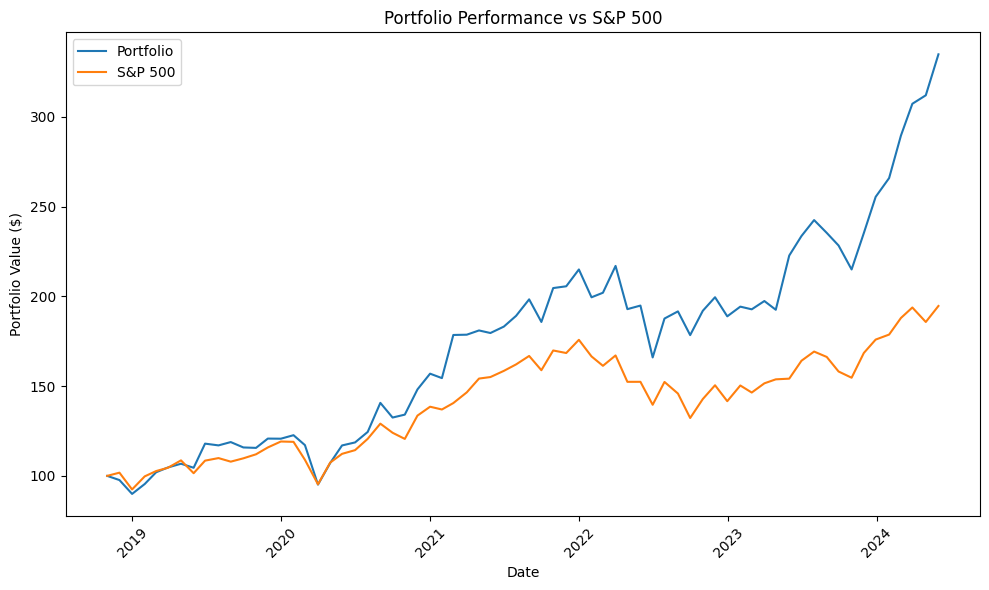

In [105]:
sp500_data = close_data['S&P500']  # You need to have this data loaded

# Call the function
performance_df = create_portfolio_and_compare(scores, close_data, sp500_data)

# Plot the portfolio performance vs S&P 500
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(performance_df['rebalance_date'], performance_df['portfolio_value'], label='Portfolio')
plt.plot(performance_df['rebalance_date'], performance_df['sp500_value'], label='S&P 500')
plt.title('Portfolio Performance vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

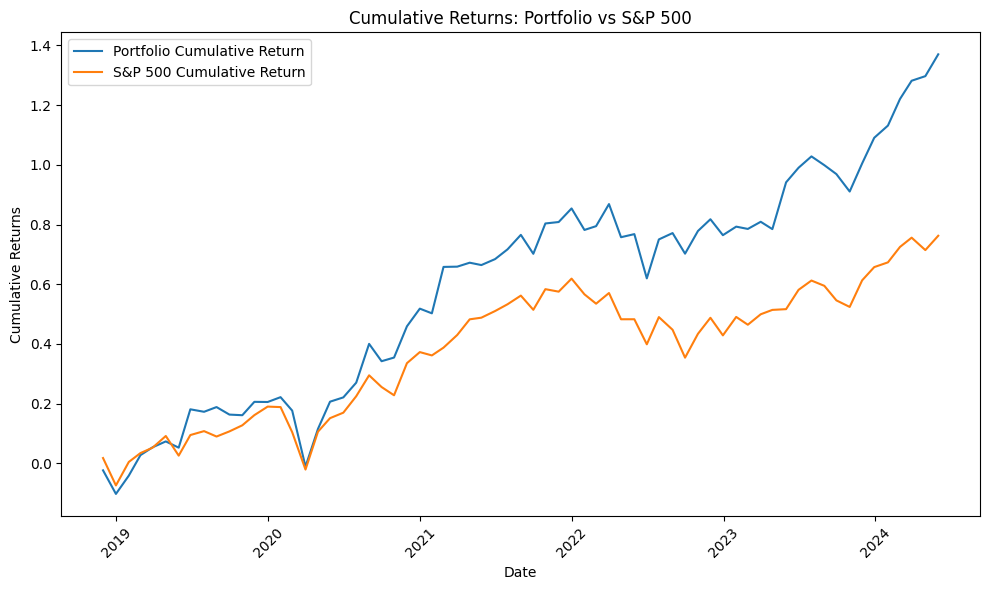

In [106]:
# Calculate cumulative returns for portfolio and S&P 500
portfolio_cumulative_return = performance_df['portfolio_value'].pct_change().cumsum()
sp500_cumulative_return = performance_df['sp500_value'].pct_change().cumsum()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(performance_df['rebalance_date'], portfolio_cumulative_return, label='Portfolio Cumulative Return')
plt.plot(performance_df['rebalance_date'], sp500_cumulative_return, label='S&P 500 Cumulative Return')
plt.title('Cumulative Returns: Portfolio vs S&P 500')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()